In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import hdbscan
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix




In [3]:
# Filter for individual customers
ddf = dd.read_parquet('transactions.parquet')
ddf_individual = ddf[ddf['CUSTOMER_TYPE'] == 'Cá nhân']

# Compute the filtered dataframe to bring it into memory as a Pandas DataFrame
df_individual = ddf_individual.compute()

# Select specific columns
df_individual = df_individual[['CUST_CUSTNO', 'total_deposits', 'total_withdrawals']]

# Display the filtered dataframe
df_individual



,CUST_CUSTNO,total_deposits,total_withdrawals
0,0000007773223f2870cd370943080c676696b5281dbe75...,120.0,-4100.0
1,00002bfa6df6d71eb18c1669be8d381641529f0dcdbb2a...,5400.0,-9600.0
2,0000c38422e04ccb772df72ed8ddac2b100b3bc88600be...,50.0,0.0
3,00010f06847bee388c69aaabcef8a3bc6221db4f9e03bf...,0.0,-5000.0
4,00013c38ac340d54e458cc923fbfed7171c5586877fd60...,0.0,-67453.4
...,...,...,...
195139,fffeae132cbb21f07d46942cde6fe6af1895e37de37fec...,0.0,-27.0
195140,fffedbd9aabeeb0fbd3267484e5afa3ddbe03834319602...,0.0,-389.0
195141,ffff174fed6d742e6eb7b30843430e86fd6281ef8d96b4...,367.0,-671.75
195142,ffff9730c2642fc5484a35fef7543417deced83c277fab...,1100.0,-500.0


In [4]:
# Log Transform the Data
df_individual['log_total_deposits'] = np.log1p(df_individual['total_deposits'])
df_individual['log_total_withdrawals'] = np.log1p(df_individual['total_withdrawals'].abs())

In [5]:
# Prepare the data for clustering
features = df_individual[['log_total_deposits', 'log_total_withdrawals']].values


In [6]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

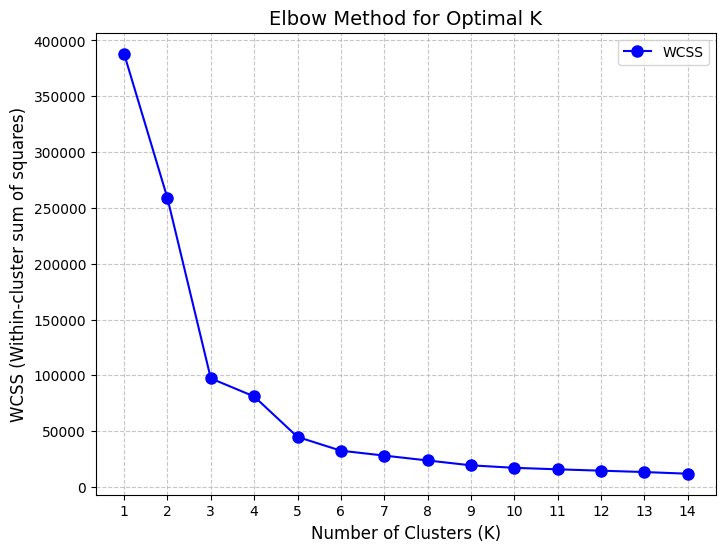

The optimal number of clusters (K) is: 3


In [91]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 10. Apply K-means clustering with different K values and compute WCSS (within-cluster sum of squares)
wcss = []
K_range = range(1, 15)  # We will try K from 1 to 15

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS for the clusters

# 11. Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(K_range, wcss, 'bo-', markersize=8, marker='o', color='b', label='WCSS')
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Within-cluster sum of squares)', fontsize=12)
plt.xticks(K_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# 12. Determine the optimal K based on the "elbow" point
# The elbow is the point where the rate of decrease in WCSS slows down significantly.
# Find the optimal K by looking at the largest change in WCSS between consecutive K values

optimal_k = K_range[0]
largest_diff = 0

for i in range(1, len(wcss)):
    diff = wcss[i-1] - wcss[i]
    if diff > largest_diff:
        largest_diff = diff
        optimal_k = K_range[i]

print(f"The optimal number of clusters (K) is: {optimal_k}")


In [7]:
# Set the number of clusters
n_clusters = 3

In [8]:
# 10. Apply K-Means Clustering (We will use 3 clusters based on Elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)


In [9]:
# Add the K-means labels to the transactions dataframe
df_individual['kmeans_label'] = kmeans_labels
df_individual

,CUST_CUSTNO,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,kmeans_label
0,0000007773223f2870cd370943080c676696b5281dbe75...,120.0,-4100.0,4.795791,8.318986,2
1,00002bfa6df6d71eb18c1669be8d381641529f0dcdbb2a...,5400.0,-9600.0,8.594339,9.169623,2
2,0000c38422e04ccb772df72ed8ddac2b100b3bc88600be...,50.0,0.0,3.931826,0.0,0
3,00010f06847bee388c69aaabcef8a3bc6221db4f9e03bf...,0.0,-5000.0,0.0,8.517393,1
4,00013c38ac340d54e458cc923fbfed7171c5586877fd60...,0.0,-67453.4,0.0,11.119207,1
...,...,...,...,...,...,...
195139,fffeae132cbb21f07d46942cde6fe6af1895e37de37fec...,0.0,-27.0,0.0,3.332205,1
195140,fffedbd9aabeeb0fbd3267484e5afa3ddbe03834319602...,0.0,-389.0,0.0,5.966147,1
195141,ffff174fed6d742e6eb7b30843430e86fd6281ef8d96b4...,367.0,-671.75,5.908083,6.511374,2
195142,ffff9730c2642fc5484a35fef7543417deced83c277fab...,1100.0,-500.0,7.003974,6.216606,2


In [10]:
total_samples = len(df_individual)
cluster_counts = df_individual['kmeans_label'].value_counts()
print("Cluster Counts and Percentage of Samples:")
for cluster_label, count in cluster_counts.items():
  percentage = (count / total_samples) * 100
  print(f"Cluster {cluster_label}: Count = {count}, Percentage = {percentage:.2f}%")


Cluster Counts and Percentage of Samples:
Cluster 1: Count = 88941, Percentage = 45.84%
Cluster 2: Count = 69306, Percentage = 35.72%
Cluster 0: Count = 35796, Percentage = 18.45%


In [11]:
# Step 5: Compute distance of each point to its cluster centroid
distances = np.linalg.norm(features_scaled - kmeans.cluster_centers_[df_individual['kmeans_label']], axis=1)

# Compute statistics on the distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)
min_distance = np.min(distances)
max_distance = np.max(distances)
# Print statistics
print(f"Mean Distance: {mean_distance:.4f}")
print(f"Standard Deviation: {std_distance:.4f}")
print(f"Min Distance: {min_distance:.4f}")
print(f"Max Distance: {max_distance:.4f}")


Mean Distance: 0.5682
Standard Deviation: 0.4223
Min Distance: 0.0033
Max Distance: 4.3185


In [33]:
# Step 5: Compute distance of each point to its cluster centroid
distances = np.linalg.norm(features_scaled - kmeans.cluster_centers_[df_individual['kmeans_label']], axis=1)

# Step 6: Set an anomaly threshold (e.g., top 5% of distances)
threshold = 2
df_individual['anomaly_kmeans'] = distances > threshold  # True if it's an anomaly

In [34]:
# Step 7: Add scoring based on distances (you can directly use the distance as the score)
df_individual['anomaly_score_kmeans'] = distances

# Display the dataframe with the anomaly flags and scores
print(df_individual[['CUST_CUSTNO', 'total_deposits', 'total_withdrawals',  'anomaly_score_kmeans', 'anomaly_kmeans']].head())

                                         CUST_CUSTNO  total_deposits  \
0  0000007773223f2870cd370943080c676696b5281dbe75...           120.0   
1  00002bfa6df6d71eb18c1669be8d381641529f0dcdbb2a...          5400.0   
2  0000c38422e04ccb772df72ed8ddac2b100b3bc88600be...            50.0   
3  00010f06847bee388c69aaabcef8a3bc6221db4f9e03bf...             0.0   
4  00013c38ac340d54e458cc923fbfed7171c5586877fd60...             0.0   

   total_withdrawals  anomaly_score_kmeans  anomaly_kmeans  
0            -4100.0              0.905515           False  
1            -9600.0              0.166427           False  
2                0.0              0.671515           False  
3            -5000.0              0.665803           False  
4           -67453.4              1.411606           False  


In [35]:
# Apply rule 15 to df_individual
rule_15_anomalies = df_individual[
    (
        (df_individual['total_deposits'].abs() >= 6000000) | (df_individual['total_withdrawals'].abs() >= 6000000)
    ) & 
    (df_individual['total_withdrawals'].abs() >= 0.95 * df_individual['total_deposits'])
]

rule_15_anomalies



,CUST_CUSTNO,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,kmeans_label,anomaly_kmeans,anomaly_score_kmeans,true_anomaly,predicted_anomaly
51,001649736bcafeaf5a9c1c5c5262a7d4451df41b9c222c...,8593437.78,-8508170.64,15.96651,15.956538,2,True,2.730665,True,1
1204,0191cf57de3d54f5112226efd558e976c801681f4736b5...,14023666.97,-14022647.25,16.456257,16.456184,2,True,2.914885,True,1
1287,01a933d4323788d065e400b4b90eaa1e702f3fc5709574...,7889532.14,-7820273.19,15.881048,15.87223,2,True,2.699164,True,1
1543,0202c9077426bdc83d1a46df8e062738c27632e1c35238...,13707567.12,-13603783.61,16.433459,16.425859,2,True,2.904726,True,1
1621,0220168858cafaa2b38ef9fdc33c7ddabf9bf5716ab926...,21965418.69,-21960000.0,16.90498,16.904733,2,True,3.081601,True,1
...,...,...,...,...,...,...,...,...,...,...
193300,fd9d7f98599e30315fbf5284f7a35ca8e52f9b10fcb43e...,8204558.9,-24204558.94,15.920201,17.002052,2,True,2.964684,True,1
193500,fddd7fc2e0f3c95224ea676ca6b090b64183f6f52a9804...,10594759.43,-10570500.01,16.17587,16.173578,2,True,2.810189,True,1
193953,fe6b387f78da8da0167ba9cf4ffe2bacbf78f4061f74dc...,4254749.68,-6409499.2,15.263547,15.673292,2,True,2.564608,True,1
194243,fed6e67003861462eb13e4fdd8e4923a21e2bc84f0be07...,78002809.43,-77317404.71,18.172255,18.16343,2,True,3.550629,True,1


In [36]:
# Step 8: Count the detected anomalies
print(df_individual['anomaly_kmeans'].value_counts())

anomaly_kmeans
False    191663
True       2380
Name: count, dtype: int64


In [37]:
# Step 1: Create ground truth labels (1 if in Rule 15 anomalies, else 0)
df_individual['true_anomaly'] = df_individual.index.isin(rule_15_anomalies.index)

# Step 2: Get K-Means anomaly labels (1 for anomaly, 0 for normal)
df_individual['predicted_anomaly'] = df_individual['anomaly_kmeans'].astype(int)

# Step 3: Compute Precision and Recall
precision = precision_score(df_individual['true_anomaly'], df_individual['predicted_anomaly'])
recall = recall_score(df_individual['true_anomaly'], df_individual['predicted_anomaly'])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 0.2021
Recall: 1.0000


In [38]:
# Print the unique cluster values from the rule_15_anomalies dataframe
print("Unique clusters in rule_15_anomalies:")
print(rule_15_anomalies['kmeans_label'].unique())


Unique clusters in rule_15_anomalies:
[2 1]


In [39]:
rule15_cif = pd.read_excel('CIF_HASH 14122024.xlsx')
rule15_cif = rule15_cif[['CUST']]
rule15_cif = rule15_cif.rename(columns={'CUST': 'CUST_CUSTNO'})
rule15_cif


,CUST_CUSTNO
0,4a7ac6a7d71c8dd43d07ea99ed57b947d4625ffb1ee7ba...
1,5ff908d766a8431c0480eaaa66f0c7f4f981ea36bb09db...
2,b585979be38eb995869128769142e7299db20874f0d8be...
3,55eeb636a10285eb1f8f8f5a6c2a8f210b2c5cc673546e...
4,039444b700a770ced03250af136ba9c2578a7136ef800d...
5,704f2775efdf525bc5319d057fc066417f464811e2889d...
6,fd9d7f98599e30315fbf5284f7a35ca8e52f9b10fcb43e...
7,21bc03333bc9f8a30ab9e8a05fbe675320dab245e282d3...
8,c7d19d1ad02b35b3a8c43f8381705ceac0a2c31cde3740...


In [40]:
ddf_filteredx = rule_15_anomalies.merge(rule15_cif, on='CUST_CUSTNO', how='right')
ddf_filteredx

,CUST_CUSTNO,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,kmeans_label,anomaly_kmeans,anomaly_score_kmeans,true_anomaly,predicted_anomaly
0,4a7ac6a7d71c8dd43d07ea99ed57b947d4625ffb1ee7ba...,42728096.58,-65899418.85,17.570367,18.00364,2,True,3.426906,True,1
1,5ff908d766a8431c0480eaaa66f0c7f4f981ea36bb09db...,19900681.84,-21928607.94,16.806265,16.903303,2,True,3.066768,True,1
2,b585979be38eb995869128769142e7299db20874f0d8be...,7273818.15,-21352635.78,15.799792,16.876686,2,True,2.918877,True,1
3,55eeb636a10285eb1f8f8f5a6c2a8f210b2c5cc673546e...,39516937.48,-58818914.14,17.49224,17.889974,2,True,3.389777,True,1
4,039444b700a770ced03250af136ba9c2578a7136ef800d...,8373577.74,-23412154.89,15.940592,16.968766,2,True,2.959609,True,1
5,704f2775efdf525bc5319d057fc066417f464811e2889d...,9248178.16,-27496356.23,16.039937,17.129564,2,True,3.010907,True,1
6,fd9d7f98599e30315fbf5284f7a35ca8e52f9b10fcb43e...,8204558.9,-24204558.94,15.920201,17.002052,2,True,2.964684,True,1
7,21bc03333bc9f8a30ab9e8a05fbe675320dab245e282d3...,7912330.19,-23524660.28,15.883933,16.97356,2,True,2.953071,True,1
8,c7d19d1ad02b35b3a8c43f8381705ceac0a2c31cde3740...,15326286.31,-45567572.46,16.54508,17.634707,2,True,3.198212,True,1
